# Model analysis

In [15]:
from datetime import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import mlflow 
import pandas as pd

from utils.logger import logger

In [10]:
sns.set_theme(
    context="notebook", style="ticks", rc={"figure.figsize": (11.7 / 2, 8.27 / 2)}
)

In [11]:
logger.info("torch version %s", torch.__version__)

In [13]:
# use gpu if available, else cpu
has_cuda = torch.cuda.is_available()

logger.info("Is the GPU available? %s", has_cuda)
device = torch.device("cuda" if has_cuda else "cpu")

if has_cuda:
    logger.info("Current device: %s", torch.cuda.current_device())
    logger.info("Device count: %s", torch.cuda.device_count())
    torch.cuda.set_device(0)
    logger.info("Using device: %s", torch.cuda.get_device_properties(device))
else:
    logger.warning("No GPU dectected! Training will be extremly slow")

No GPU dectected! Training will be extremly slow


## Loading the models

In [27]:
server_ip = "pc049713.ds.umcutrecht.nl"

os.environ["AWS_ACCESS_KEY_ID"] = "minio"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio123"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://{server_ip}:9000"

mlflow.set_tracking_uri(f"http://{server_ip}:5000")

df_frames = list()

run_infos = mlflow.list_run_infos("1", run_view_type=mlflow.entities.ViewType.ACTIVE_ONLY)
for run_info in run_infos:
    logger.debug("Loading run info for: %s", run_info.run_uuid)

    run = mlflow.get_run(run_info.run_uuid)
    
    metrics = {f"metrics_{key}": val for key, val in run.data.metrics.items()}
    params = {f"params_{key}": val for key, val in run.data.params.items()}
    
    features_dict = {**dict(run.info), **metrics, **params}
    
    df_tmp = pd.DataFrame.from_records([features_dict])
    
    df_tmp["end_time"] = pd.to_datetime(df_tmp["end_time"], unit="ms")
    df_tmp["start_time"] = pd.to_datetime(df_tmp["start_time"], unit="ms")
    
    df_frames.append(df_tmp)
    
df_runs = pd.concat(df_frames)
df_runs = df_runs.set_index('start_time')
df_runs.head()

,artifact_uri,end_time,experiment_id,lifecycle_stage,run_id,run_uuid,status,user_id,metrics_best_score,metrics_mean_max,...,params_sync_batchnorm,params_terminate_on_nan,params_tpu_cores,params_track_grad_norm,params_truncated_bptt_steps,params_val_check_interval,params_verbose,params_weights_save_path,params_weights_summary,params_weight_decay
start_time,,,,,,,,,,,,,,,,,,,,,
2021-09-04 17:16:27.073,s3://mlflow-artifacts/1/109980eb9e2a4ddf814f58...,2021-09-05 02:50:55.712,1,active,109980eb9e2a4ddf814f58fb9f7702aa,109980eb9e2a4ddf814f58fb9f7702aa,FINISHED,maarten,0.997986,0.998011,...,False,False,None,-1,None,1.0,10,None,top,0
2021-09-03 14:10:34.151,s3://mlflow-artifacts/1/adc7fdca31a24a9da7e668...,2021-09-04 00:09:40.068,1,active,adc7fdca31a24a9da7e6689d7a73fbe8,adc7fdca31a24a9da7e6689d7a73fbe8,FINISHED,maarten,0.997999,0.998028,...,False,False,None,-1,None,1.0,10,None,top,0


In [28]:
df_runs.iloc[0]["artifact_uri"]

's3://mlflow-artifacts/1/109980eb9e2a4ddf814f58fb9f7702aa/artifacts'

In [31]:
mlflow.pytorch.load_model("s3://mlflow-artifacts/1/109980eb9e2a4ddf814f58fb9f7702aa/artifacts/model")

2021/09/07 15:52:35 WARNING mlflow.pytorch: Stored model version '1.9.0' does not match installed PyTorch version '1.9.0+cu102'


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

## Model evalutation

In [11]:
IMAGES_PATH = Path(ROOT_PATH, "images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

### Reconstruction loss (MSE) for each model

In [13]:
def predict(subject, model_path, n_features, decoder, exclude):
    # create the data set
    data_set = MRISelectorSubjDataset(
        Path(ROOT_PATH, "data"),
        "data_.hdf5",
        "header_.csv",
        np.array([subject]),
        exclude=exclude,
    )
    data_gen = DataLoader(
        data_set,
        batch_size=265,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )

    # construct the model
    model = ConcreteSelect(
        output_dim=n_features,
        n_features=n_features,
        input_shape=1344 - len(exclude),
        decoder=decoder,
        device=device,
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # make the prediction
    predictions = list()
    with torch.no_grad():
        for batch in data_gen:
            batch = batch.to(device)
            prediction, _ = model(batch)
            predictions.append(prediction)

    # return ground truth and prediction
    return torch.from_numpy(data_set.data), torch.abs(
        torch.cat(predictions, 0).to("cpu")
    )


mse_loss = torch.nn.MSELoss(reduction="mean").to(device)


def calc_loss(row, subject):

    target, prediction = predict(
        subject,
        row["params_path"],
        row["n_features"],
        decoder_dict[row["decoder"]],
        row["exclude"],
    )

    loss = mse_loss(prediction, target).to("cpu")

    offset = 0

    losses = np.full(1344 + 1, np.nan)
    losses[0] = loss
    for i in range(1344):
        if i == target.size(1):
            break
        if i in row["exclude"]:
            offset += 1
        loss = mse_loss(prediction[:, i - offset], target[:, i - offset]).to("cpu")
        losses[i + 1 + offset] = loss.item()

    return losses

In [13]:
df_filtered = df[df.exclude.apply(str) == "[]"]
df_loss = df_filtered.apply(calc_loss, axis=1, args=[15], result_type="expand")
column_names = ["avg"]
for i in range(1344):
    column_names.append(str(i))

df_loss.columns = column_names
df_loss.head()

,avg,0,1,2,3,4,5,6,7,8,...,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343
datetime,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:15:25,0.193343,0.006148,0.019698,0.017613,0.034235,0.240398,0.098785,0.505971,0.156972,0.003655,...,0.114563,0.061163,0.003512,0.046205,0.069097,0.042482,0.002414,0.011520,0.013058,0.036245
2021-06-29 00:47:25,0.218500,0.007250,0.010522,0.087184,0.102565,0.231192,0.090180,0.516702,0.531069,0.005441,...,0.012578,0.013510,0.001500,0.012823,0.078625,0.052974,0.011877,0.012288,0.010150,0.075219
2021-07-01 05:30:27,0.199338,0.075228,0.019012,0.061590,0.095495,0.103487,0.087942,0.229712,0.360119,0.006678,...,0.039835,0.030770,0.003789,0.017136,0.065214,0.069497,0.002666,0.013630,0.020029,0.097611
2021-06-30 14:09:54,0.218174,0.004884,0.018173,0.075236,0.108458,0.241424,0.188789,0.448791,0.613964,0.004827,...,0.010240,0.006604,0.001798,0.052941,0.090102,0.110048,0.026863,0.017309,0.009732,0.071678
2021-06-28 19:31:11,0.239409,0.007239,0.022315,0.061538,0.106785,0.251164,0.180051,0.504361,0.681769,0.010912,...,0.014189,0.013509,0.004850,0.049283,0.053376,0.112269,0.002363,0.007667,0.021628,0.129302


In [14]:
df = pd.merge(df, df_loss["avg"], on="datetime")
df = df.rename(columns={"avg": "loss"})
df

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss
datetime,,,,,,,,,,
2021-07-01 00:15:25,0.001,256,2000,336,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.193343
2021-06-29 00:47:25,0.001,256,2000,42,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.218500
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338
2021-06-30 14:09:54,0.001,256,2000,168,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.218174
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.239409
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.226511
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.231744
2021-06-30 04:53:13,0.001,256,2000,168,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206289
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145


In [15]:
df = df.sort_values(by=["n_features", "decoder"])

In [16]:
df_loss_tmp = df_loss.T
df_loss_tmp["feature"] = df_loss_tmp.index

dfs = list()
for column in df_loss_tmp.columns[:-1]:
    tmp = pd.DataFrame(df_loss_tmp)
    tmp["datetime"] = column
    tmp = tmp[[column, "datetime", "feature"]]
    tmp.columns = ["loss", "datetime", "feature"]
    dfs.append(tmp)

df_loss = pd.concat(dfs)
df_loss = df_loss.set_index("datetime")

In [17]:
df_loss = pd.merge(df, df_loss, on=["datetime"])
df_loss

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss_x,loss_y,feature
datetime,,,,,,,,,,,,
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.206990,avg
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.005845,0
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.022328,1
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.083459,2
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.206990,0.066316,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.069497,1339
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.002666,1340
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.199338,0.013630,1341


In [25]:
df_loss[df_loss.feature == "912"]
df_loss.sort_values(by="loss_y")

,lr,batch_size,num_epochs,n_features,decoder,test,params_path,features_path,exclude,loss_x,loss_y,feature
datetime,,,,,,,,,,,,
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000470,576
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.239409,0.000478,576
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000509,940
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.232145,0.000523,1224
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.226511,0.000527,912
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29 14:51:26,0.001,256,2000,84,decoder_1l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.215748,22.550230,55
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.226511,22.581549,55
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,[],0.231744,22.732161,55


### Plot average loss

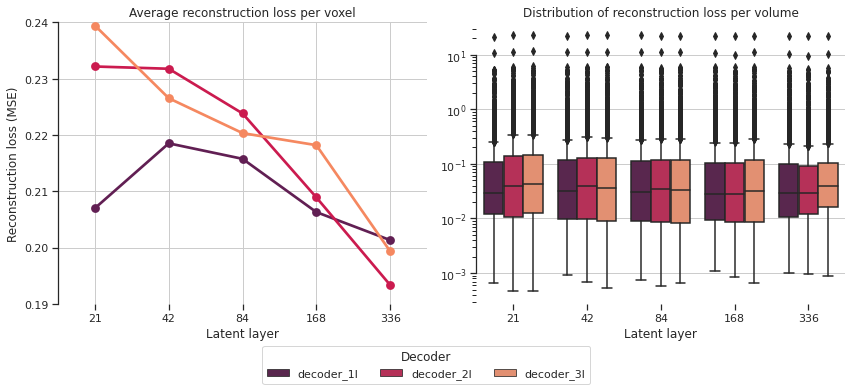

In [18]:
df_loss_filtered = df_loss[df_loss.exclude.apply(str) == "[]"]

fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5))

plot = sns.pointplot(
    x="n_features",
    y="loss",
    hue="decoder",
    hue_order=["decoder_1l", "decoder_2l", "decoder_3l"],
    data=df[
        df.exclude.apply(str) == "[]"
    ],  # boolean index on models that do not exclude features (ie: empty list in 'exclude' row)
    palette="rocket",
    ax=axes[0],
)
plot.set(
    xlabel="Latent layer",
    ylabel="Reconstruction loss (MSE)",
    title="Average reconstruction loss per voxel",
)
axes[0].set_ylim(0.19, 0.24)
axes[0].yaxis.grid(True)
axes[0].xaxis.grid(True)
axes[0].get_legend().remove()

plot = sns.boxplot(
    x="n_features",
    y="loss_y",
    hue="decoder",
    hue_order=["decoder_1l", "decoder_2l", "decoder_3l"],
    data=df_loss_filtered,
    palette="rocket",
    orient="v",
    ax=axes[1],
)
plot.set(
    xlabel="Latent layer",
    ylabel="",
    title="Distribution of reconstruction loss per volume",
)
axes[1].set_yscale("log")
axes[1].yaxis.grid(True)
axes[1].get_legend().remove()

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    title="Decoder",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
)

sns.despine(trim=True, bottom=True)

plt.tight_layout()

image_path = Path(IMAGES_PATH, "reconstruction_loss_(MSE).pdf")
plt.savefig(image_path, bbox_inches="tight");

### Plot feature occurence count

Some features occure multiple times in a single model. Lets plot the top 20 most occuring features.

In [26]:
def get_feat_count(row):
    features = np.loadtxt(row["features_path"], dtype=np.int64)
    counts = np.bincount(features)
    counts_df = pd.DataFrame(counts, columns=["count"])
    return counts_df


def get_feat_counts(data):
    counts_dfs = []
    if type(data) is pd.DataFrame:
        for _, row in data.iterrows():
            counts_df = get_feat_count(row)
            counts_dfs.append(counts_df)
    else:  # assume it is a Series
        counts_df = get_feat_count(data)
        counts_dfs.append(counts_df)
    # sum all the bin counts
    df_counts = pd.concat(counts_dfs).groupby(level=0).sum().reset_index()
    return df_counts


df_counts_total = get_feat_counts(df.iloc[:-2])
df_counts_1 = get_feat_counts(df.iloc[-3])
df_counts_exclude_1 = get_feat_counts(df.iloc[-2])
df_counts_exclude_2 = get_feat_counts(df.iloc[-1])
df_counts_2 = get_feat_counts(df.iloc[-5])
df_counts_3 = get_feat_counts(df.iloc[-4])

In [27]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """Code from https://stackoverflow.com/a/56780852/6131485"""

    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() - float(space)
                _y = p.get_y() + p.get_height() - 0.2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="right", c="white")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

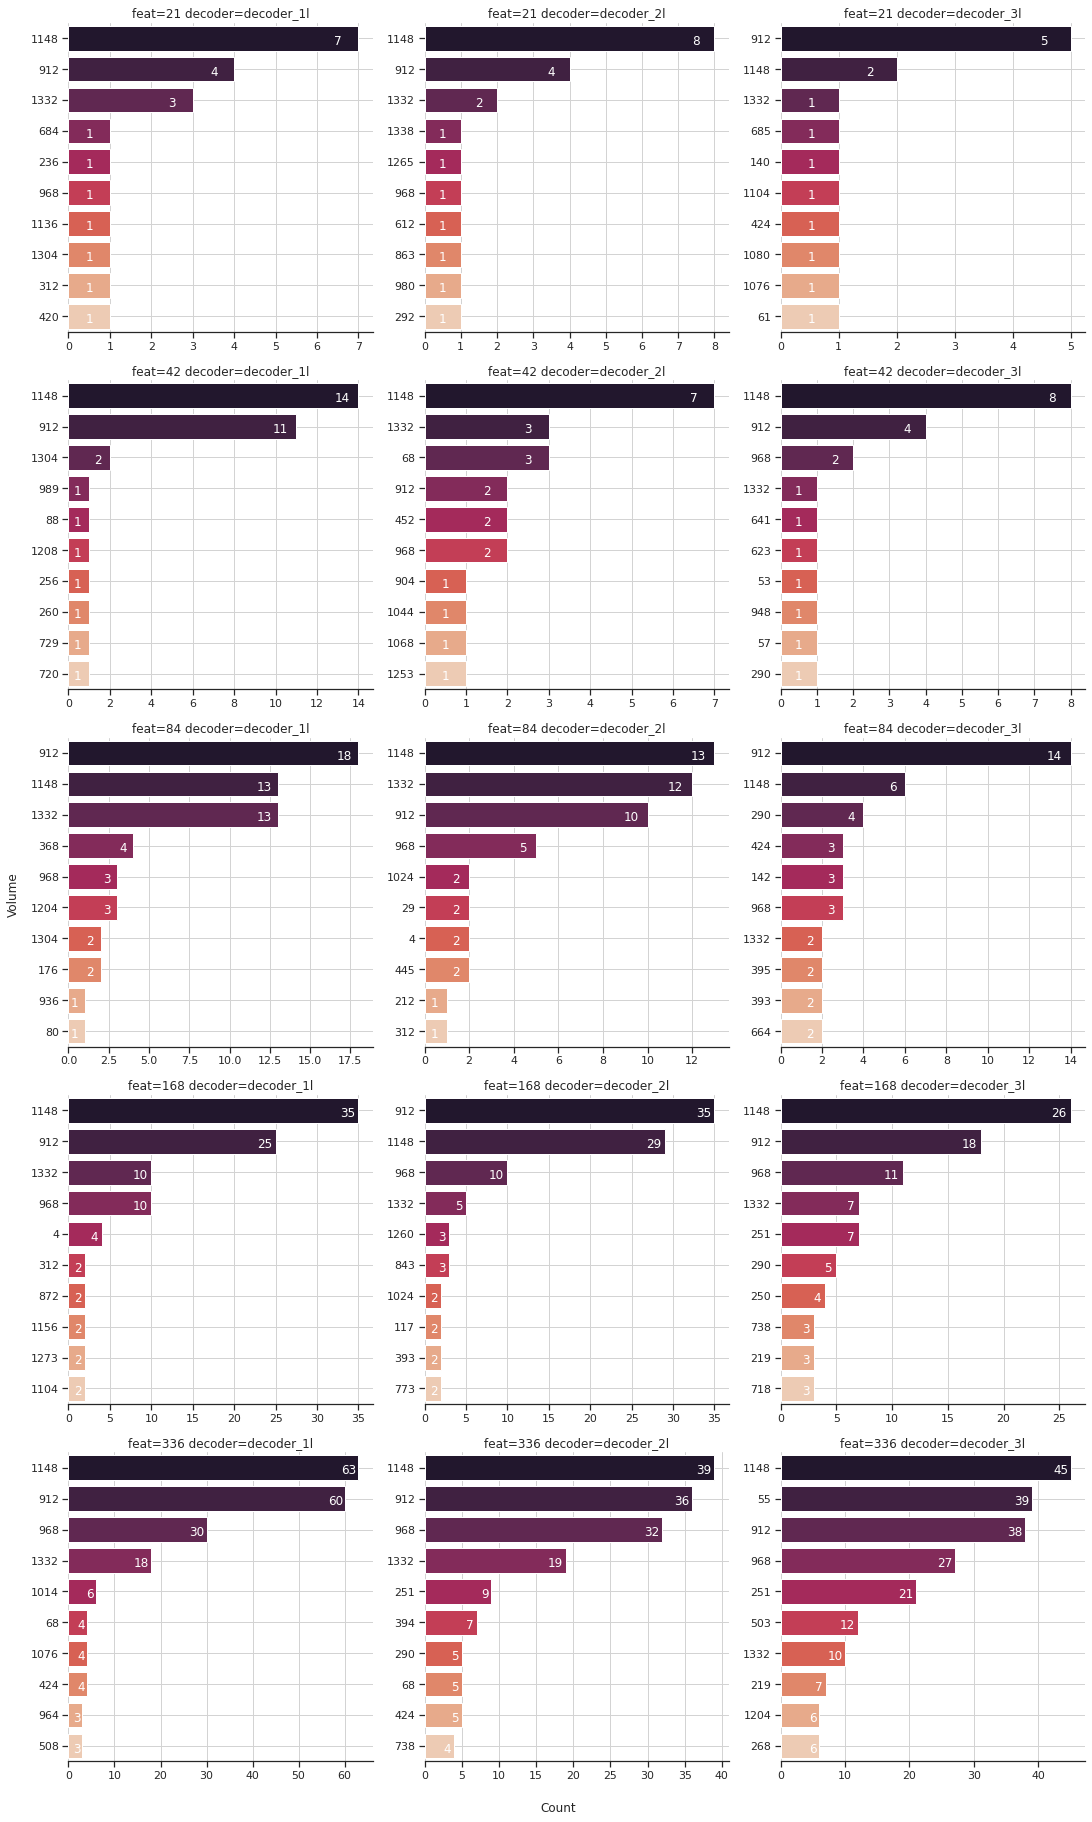

In [30]:
def plot_counts(df, top_size=10, ax=None, title=None):
    df_counts = df.sort_values(by="count", ascending=False)[:top_size]
    plot = sns.barplot(
        orient="h",
        x="count",
        y="index",
        data=df_counts,
        order=df_counts["index"].values,
        palette="rocket",
        ax=ax,
    )
    plot.set(xlabel=None, ylabel=None, title=title)
    show_values_on_bars(plot, "h")
    if ax is not None:
        ax.grid(True, which="both", ls="-", c="lightgray")


fig, axes = plt.subplots(5, 3, figsize=(5 * 3, 5 * 5))
# fig.suptitle("Volume counts for each model", x=0.5, y=1)
fig.text(0.5, -0.01, "Count", ha="center")
fig.text(-0.01, 0.5, "Volume", va="center", rotation="vertical")

for i, ax in enumerate(axes.flatten()):
    row = df.iloc[i]
    df_counts = get_feat_counts(row)
    plot_counts(
        df_counts, ax=ax, title=f"feat={row['n_features']} decoder={row['decoder']}"
    )

sns.despine(left=True)

plt.tight_layout()

image_path = Path(IMAGES_PATH, "feature_count.pdf")
plt.savefig(image_path, bbox_inches="tight");

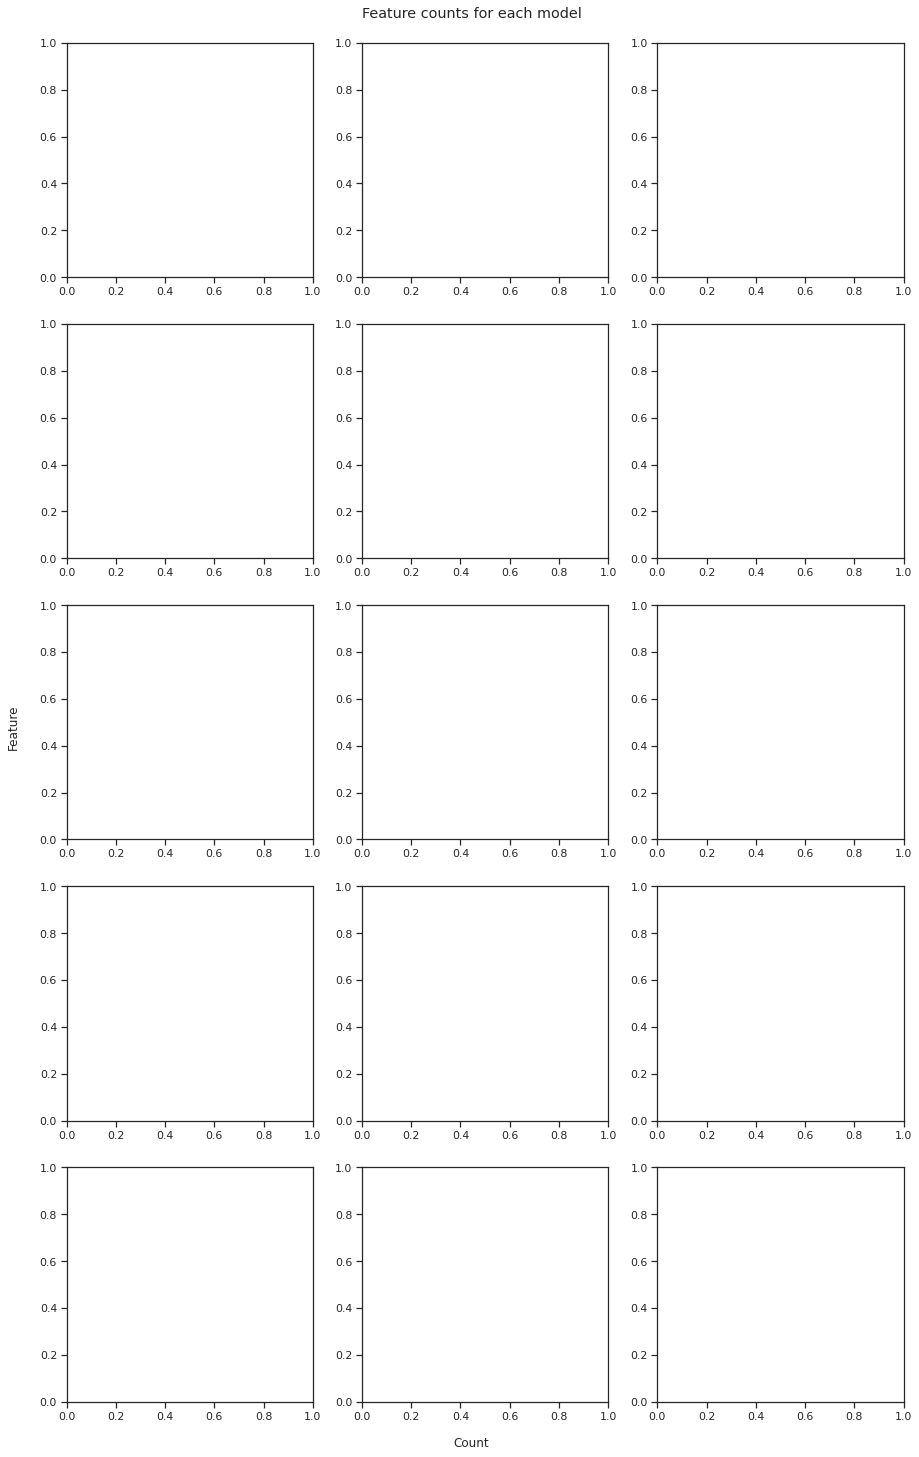

In [29]:
fig, axes = plt.subplots(5, 3, figsize=(5 * 3, 5 * 5))
fig.suptitle("Feature counts for each model", x=0.5, y=0.9)
fig.text(0.5, 0.1, "Count", ha="center")
fig.text(0.07, 0.5, "Feature", va="center", rotation="vertical")

for i, ax in enumerate(axes.flatten()):
    try:
        row = df.iloc[15 + i]
        df_counts = get_feat_counts(row)
        plot_counts(
            df_counts, ax=ax, title=f"feat={row['n_features']} decoder={row['decoder']}"
        )
    except IndexError:
        continue
image_path = Path(IMAGES_PATH, "feature_count_exclude.pdf")
plt.savefig(image_path, bbox_inches="tight");

### Interactive model plot

In [14]:
from nilearn import image, masking

In [15]:
from bokeh.io import output_notebook, show
from bokeh.layouts import column, row
from bokeh.models import (
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    PreText,
    RadioButtonGroup,
    Select,
    Slider,
    Spinner,
)
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [20]:
def load_drmi(row_index):
    target, prediction = predict(
        15,
        df.iloc[row_index]["params_path"],
        df.iloc[row_index]["n_features"],
        decoder_dict[df.iloc[row_index]["decoder"]],
        df.iloc[row_index]["exclude"],
    )

    target_img = masking.unmask(
        np.transpose(target.numpy()),
        "/media/disk1/MUDI/cdmri0015/brain_mask.nii.gz",
    )
    prediction_img = masking.unmask(
        np.transpose(prediction.numpy()),
        "/media/disk1/MUDI/cdmri0015/brain_mask.nii.gz",
    )

    target_img = image.get_data(target_img)
    prediction_img = image.get_data(prediction_img)

    return target_img, prediction_img

In [21]:
def bkapp(doc):
    target_img, prediction_img = load_drmi(0)
    source = ColumnDataSource(dict(target=[], prediction=[]))

    x_max = target_img.shape[0] - 1
    y_max = target_img.shape[1] - 1
    z_max = target_img.shape[2] - 1
    max_values = [x_max, y_max, z_max]

    color_map = LinearColorMapper(palette="Inferno256", low=0, high=1)

    target_fig = figure(
        title="Truth",
        tooltips=[("X", "$sx"), ("Y", "$sy"), ("Value", "@target")],
        toolbar_location="below",
        output_backend="webgl",
    )
    target_fig.image(
        image="target", source=source, x=0, y=0, dw=10, dh=10, color_mapper=color_map
    )

    prediction_fig = figure(
        title="Prediction",
        tooltips=[("X", "$sx"), ("Y", "$sy"), ("Value", "@prediction")],
        x_range=target_fig.x_range,
        y_range=target_fig.y_range,
        toolbar_location="below",
        output_backend="webgl",
    )
    prediction_fig.image(
        image="prediction",
        source=source,
        x=0,
        y=0,
        dw=10,
        dh=10,
        color_mapper=color_map,
    )
    color_bar = ColorBar(color_mapper=color_map, label_standoff=12)
    prediction_fig.add_layout(color_bar, "right")

    options = list(
        zip(
            np.arange(len(df)).astype(str),
            df["params_path"].apply(lambda path: path.stem[55:-7]).tolist(),
        )
    )

    model_select = Select(
        title="Model:",
        value="0",
        options=options,
    )
    slice_slider = Slider(start=0, end=x_max, value=0, step=1, title="Slice")
    feature_slider = Spinner(low=0, high=1343, value=0, step=1, title="Feature:")
    axis_radio = RadioButtonGroup(labels=["X", "Y", "Z"], active=0)

    def model_update():
        target_img, prediction_img = load_drmi(int(model_select.value))
        update()

    def update():
        feature_value = feature_slider.value
        axis_value = axis_radio.active

        slice_slider.end = max_values[axis_value]
        if slice_slider.value > slice_slider.end:
            slice_slider.value = slice_slider.end

        slice_value = slice_slider.value

        if axis_value == 0:  # X
            source.data = dict(
                target=[target_img[slice_value, :, :, feature_value]],
                prediction=[prediction_img[slice_value, :, :, feature_value]],
            )
        elif axis_value == 1:  # Y
            source.data = dict(
                target=[target_img[:, slice_value, :, feature_value]],
                prediction=[prediction_img[:, slice_value, :, feature_value]],
            )
        elif axis_value == 2:  # Z
            source.data = dict(
                target=[target_img[:, :, slice_value, feature_value]],
                prediction=[prediction_img[:, :, slice_value, feature_value]],
            )

    model_select.on_change("value", lambda attr, old, new: model_update())
    slice_slider.on_change("value", lambda attr, old, new: update())
    feature_slider.on_change("value", lambda attr, old, new: update())
    axis_radio.on_change("active", lambda attr, old, new: update())

    layout = row(
        column(model_select, axis_radio, feature_slider, slice_slider),
        target_fig,
        prediction_fig,
    )
    doc.add_root(layout)

In [23]:
show(bkapp)

In [ ]:
show(bkapp)